In [1]:
import numpy as np
import os
import pandas as pd
import json
import folium
import branca
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import IFrame, Image
from ipywidgets import interact

%matplotlib inline

In [2]:
folium.__version__ == '0.5.0'

True

We were given the instruction that the unemployed rate of Switzerland on https://www.amstat.ch/v2/index.jsp also contained the people that were not jobless but looking for a job, which didn't make sense with the documentation on https://www.amstat.ch/v2/index.jsp, the raw numbers and the comments on Mattermost.

For those reasons, we will assume that unemployed rate for Switzerland are simply "number of jobless people/Total of active population" and not "number of people looking for a job/Total of active population"

### Choice of the datasets
Regarding the European dataset on unemployment rate, we chose to use the latest annual complete dataset which is the one from January to December 2016. We could have chosen the latest complete dataset for a month, but we want to avoid the bias induced by the seasons.

To make sure that we compare rates that are comparable, we chose the Swiss dataset on unemployment rate for the same period. Moreover, we used the interface provided on https://www.amstat.ch/ to rename and select precisely the data that we are interested in.

We show the steps taken to obtain each dataset with pictures at the end of this notebook as an appendice.

## Part 1. Comparison of Switzerland's unemployed rate with the rest of Europe's

After downloading each data files, we clean them to get a cleaner and easier to read data file. Such cleaning can be done using a program such as Excel or Libreoffice. For larger files that cannot be open by these programs, we can use a script. We describe the cleaning below:
- For the european dataset we only do
- For the swiss dataset:
 - We remove the columns with the details of each month to keep only the total
 - The file contains a 2 rows header, we merge it into a single row header and translate the header names into english.
 - We move the "Total" name from the "Language region" column to the "Canton" column

Loading data and cleaning them.

In [3]:
#The europe data file
europe_data_file = 'data/european_rate_2016.csv'
europe_df = pd.read_csv(europe_data_file)

#The swiss data file excluding nationalities
swiss_data_file = 'data/swiss_rate_tot+age+lang.csv'
swiss_df = pd.read_csv(swiss_data_file, encoding="UTF-16")

#The swiss data file with nationalities
swiss_data_file_nationality = 'data/swiss_rate_2016.csv'
swiss_nat_df = pd.read_csv(swiss_data_file_nationality)

#Clean the number so that they are represented as an int
swiss_df['Jobless'] = swiss_df['Jobless'].apply(lambda x: int(x.replace("'", "")))
swiss_df['Total'] = swiss_df['Total'].apply(lambda x: int(x.replace("'", "")))

#Group the swiss dataset by canton
swiss_df_canton_grouped = swiss_df.groupby(swiss_df["Canton"]).sum()
swiss_df_canton_grouped = swiss_df_canton_grouped.reset_index()

In [4]:
#Add the nationalities to the swiss dataframe grouped by canton
swiss_nat_df = swiss_nat_df.pivot(index='Canton', columns='Nationality')['Rate']
swiss_df_canton_grouped = pd.merge(swiss_df_canton_grouped, swiss_nat_df.reset_index(), on='Canton')
del swiss_nat_df

### Europe VS Switzerland

We decided to add the Swiss data inside the Europe dataframe in order to compare Switzerland with the rest of Europe

In [5]:
europe_df = europe_df[['Name', 'Rate']]
#Create a new single row dataframe for Switzerland
swiss_country_df = pd.DataFrame(
    [['Switzerland', swiss_df_canton_grouped.loc[swiss_df_canton_grouped['Canton'] == 'Total']['Rate'].values[0]]],
    columns=['Name', 'Rate'])

#Add the single row dataframe of Switzerland to the Europe dataframe
europe_df = europe_df.append(swiss_country_df)

In [6]:
europe_topo_path = 'topojson/europe.topojson.json'
europe_json_data = json.load(open(europe_topo_path, encoding="UTF-8"))

### Choropleth

For the europe, as we couldn't personalize the styling function using the choropleth function we decided to use the TopoJson function. We did so in order to style differently when the data is not unknown which is the case for europe.

In [7]:
rate_max = max(europe_df['Rate'])
rate_min = min(europe_df['Rate'])

# color scale from min rate to max rate
color_scale = branca.colormap.linear.OrRd.scale(rate_min, rate_max)

def style_function(country):
    rate = europe_df.loc[europe_df['Name'] == country['properties']['NAME']]['Rate'].values
    if len(rate) > 0: 
        # country is in the dataframe
        return {
            'fillOpacity': 0.8,
            'weight': 0.5,
            'color': 'black',
            'fillColor': color_scale(rate)
        }
    else:
        # country is not in the dataframe, hence we put its color as black
        return {
            'fillOpacity': 0.2,
            'weight': 0.2,
            'color': 'black',
            'fillColor': 'black'
        }

In [8]:
unemployment_map = folium.Map([53,22], tiles='cartodbpositron', zoom_start=4)
g = folium.TopoJson(europe_json_data,
                'objects.europe',
                style_function=style_function,
               ).add_to(unemployment_map)

color_scale.caption = 'Unemployment Rate (%)'
color_scale.add_to(unemployment_map)
unemployment_map

When a country is greyed out, it means that the data was not provided.

### Comments on the plot above:

As we can see the recorded unemployment rate in Europe goes from around 3% to approximatelly 24%.

On average, countries around the Mediteranean Sea have the worse unemployment rate.

We can feel lucky to live in Switzerland.

## Part 2. Comparison of unemployed rates in Switzerland at the canton level

### Choropleth

With the swiss data, we have data for all cantons. Hence we can use the choropleth function which is easier and more convienient than the "TopoJson" one.

In [9]:
swiss_topo_path = r'topojson/ch-cantons.topojson.json'
swiss_json_data = json.load(open(swiss_topo_path, encoding="utf-8"))

In [10]:
# roughly the center of Switzerland
geo_swiss_center = [46.8, 8.35]

# function to draw a map without duplicating lots of code
def draw_swiss_map(df, title, column_name, **args):
    swiss_map = folium.Map(geo_swiss_center, tiles='cartodbpositron', zoom_start=7.5)

    swiss_map.choropleth(
        geo_data=swiss_json_data,
        data=df,
        topojson='objects.cantons',
        columns=['Canton', column_name],
        fill_color='OrRd',
        key_on='properties.name',
        legend_name=title,
        **args
    )
    swiss_map.save("data/{}.html".format(title))
    return IFrame("data/{}.html".format(title), height=600, width=900), swiss_map

### Unemployment rate in Switzerland at the Canton level

In [11]:
draw_swiss_map(swiss_df_canton_grouped, 'Unemployment Rate (%)', 'Rate')[0]

### All people looking for a job, jobless or not

As mentionned above, the rate we have corresponds to the proportion of people without jobs. We will visualize below the rate of people looking for a job.

In [12]:
# Adding the people looking for a new job that already have a job to the rate
swiss_df_canton_grouped['Looking for a job rate'] = swiss_df_canton_grouped['Rate'] * swiss_df_canton_grouped['Total'] / swiss_df_canton_grouped['Jobless']

In [13]:
draw_swiss_map(swiss_df_canton_grouped, 'Unemployment Rate (%)', 'Looking for a job rate')[0]

## Part 3. Difference in the rate between Swiss and foreign workers

To make sure that we use can use the colors to compare the rates between the Swiss and foreign citizens, we use the same colormap for the two following maps.

In [14]:
threshold_scale = np.linspace(
    min([swiss_df_canton_grouped['Suisses'].min(), swiss_df_canton_grouped['Etrangers'].min()]),
    max([swiss_df_canton_grouped['Suisses'].max(), swiss_df_canton_grouped['Etrangers'].max()]),
    6,
    dtype=int
).tolist()

In [15]:
draw_swiss_map(swiss_df_canton_grouped, 'Unemployment Rate (%) of Swiss Citizen', 'Suisses', threshold_scale=threshold_scale)[0]

In [16]:
draw_swiss_map(
    swiss_df_canton_grouped,
    "Unemployment Rate (%) of foreign Citizen",
    "Etrangers",
    threshold_scale=threshold_scale
)[0]

## Part 3 bis
We also wanted to show the difference on the same map by showing the difference of rates between Swiss and foreigners

In [17]:
swiss_df_canton_grouped['Foreign - Swiss'] = swiss_df_canton_grouped['Etrangers'] - swiss_df_canton_grouped['Suisses']

In [18]:
draw_swiss_map(
    swiss_df_canton_grouped,
    'Differerence Swiss Foreign Unemployment Rate (%) of Citizen',
    'Foreign - Swiss'
)[0]

## Part 3 bisbis
We also wanted to show the difference on the same map by showing the ratio othe rates between swiss and foreigners

In [19]:
swiss_df_canton_grouped['Foreign / Swiss'] = swiss_df_canton_grouped['Etrangers'] / swiss_df_canton_grouped['Suisses']

In [20]:
draw_swiss_map(
    swiss_df_canton_grouped,
    'Ratio Swiss Foreign Unemployment Rate (%) of Citizen',
    'Foreign / Swiss'
)[0]

### EXPLIQUER BIS ET BISBIS
#CANTONS PRIMITIFS

# Part 3 : age category

We use the predifined 3 ages categories provided by Amstat, that is: 15-24, 25-49 and 50+

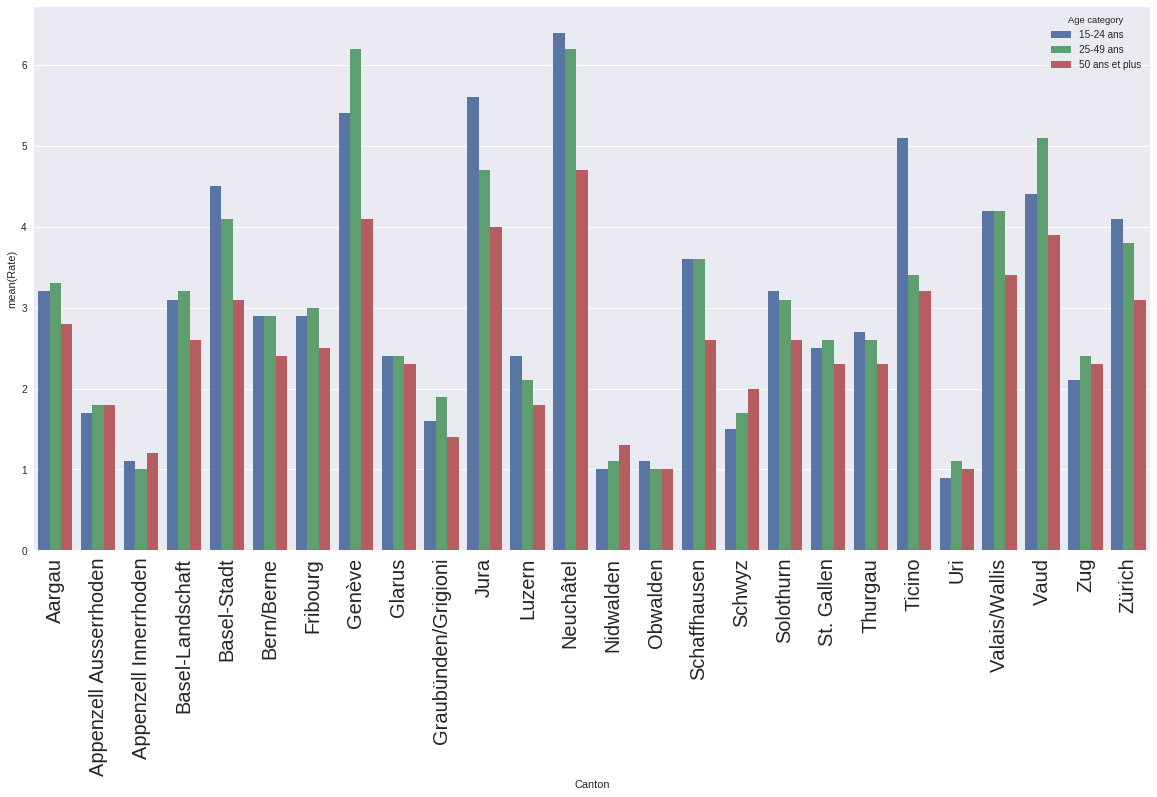

In [21]:
swiss_age_canton_df = swiss_df.groupby(["Canton", "Age category"]).sum().reset_index()
fig, ax = plt.subplots(figsize=(20,10))
plot = sns.barplot(x="Canton", y="Rate", hue="Age category", data=swiss_age_canton_df);
plot.set_xticklabels(plot.get_xticklabels(), rotation=90, size=20)
plt.show()

In [22]:
ages = ["15-24 ans", "25-49 ans", "50 ans et plus"]

def draw_map_age(age):
    return draw_swiss_map(
        swiss_age_canton_df[swiss_age_canton_df["Age category"] == age],
        "",
        "Rate",
    )[1]

In [23]:
interact(draw_map_age, age=ages)

<function __main__.draw_map_age>

# BONUS

Note that we consider the canton Ticino as part of the french side. Along the same line we do not separate "upper Valais" and "Lower Valais". We do it that way to be consistent with the data Amstat provides us.

In other words, this is a simplified version separating Latin\* cantons from the Germanic\* ones

\*(we look at the majority, we don't take into account billingual cantons)

In [24]:
# copy of swiss df without row "Total"
rosti_df = swiss_df[swiss_df['Canton'] != 'Total'].copy()

# adding a column with the weighted rate in order to compute the average rate per "röstigraben part"
rosti_df["Weighted rate"] = rosti_df["Rate"] * rosti_df["Total"]

# aggregating weighted rates with respect to their "röstigraben part" 
rosti_df = rosti_df.groupby(["Language region"])[["Weighted rate", "Total"]].sum().head()

# adding a column with the rate per "röstigraben part"
rosti_df["Rate by rösti part"] = rosti_df["Weighted rate"] / rosti_df["Total"]

swiss_df_with_rosti = pd.merge(swiss_df[swiss_df['Canton'] != 'Ticino'], rosti_df.reset_index(), on="Language region")

In [25]:
draw_swiss_map(
    swiss_df_with_rosti,
    'Unemployment Rate (%) in Röstigraben parts',
    'Rate by rösti part',
    line_weight=0,
    fill_opacity=0.7,
    smooth_factor=0.1,
)[0]

We aggregated the cantons together depending on the language spoken and computed the weighted average of the unemployed rate depending on the number of unemployed people. We can clearly see a huge difference between the Fench speaking part and the rest, the spearation is also called the "Röstigraben".

### TO-DOs:
- MAP IN HTML FORMAT!!
# MAP IN HTML HOWTO (NO ()% IN NAME)
# [Click here to view the map](Unemployment Rate.html) 

# Appendice

## Europe data

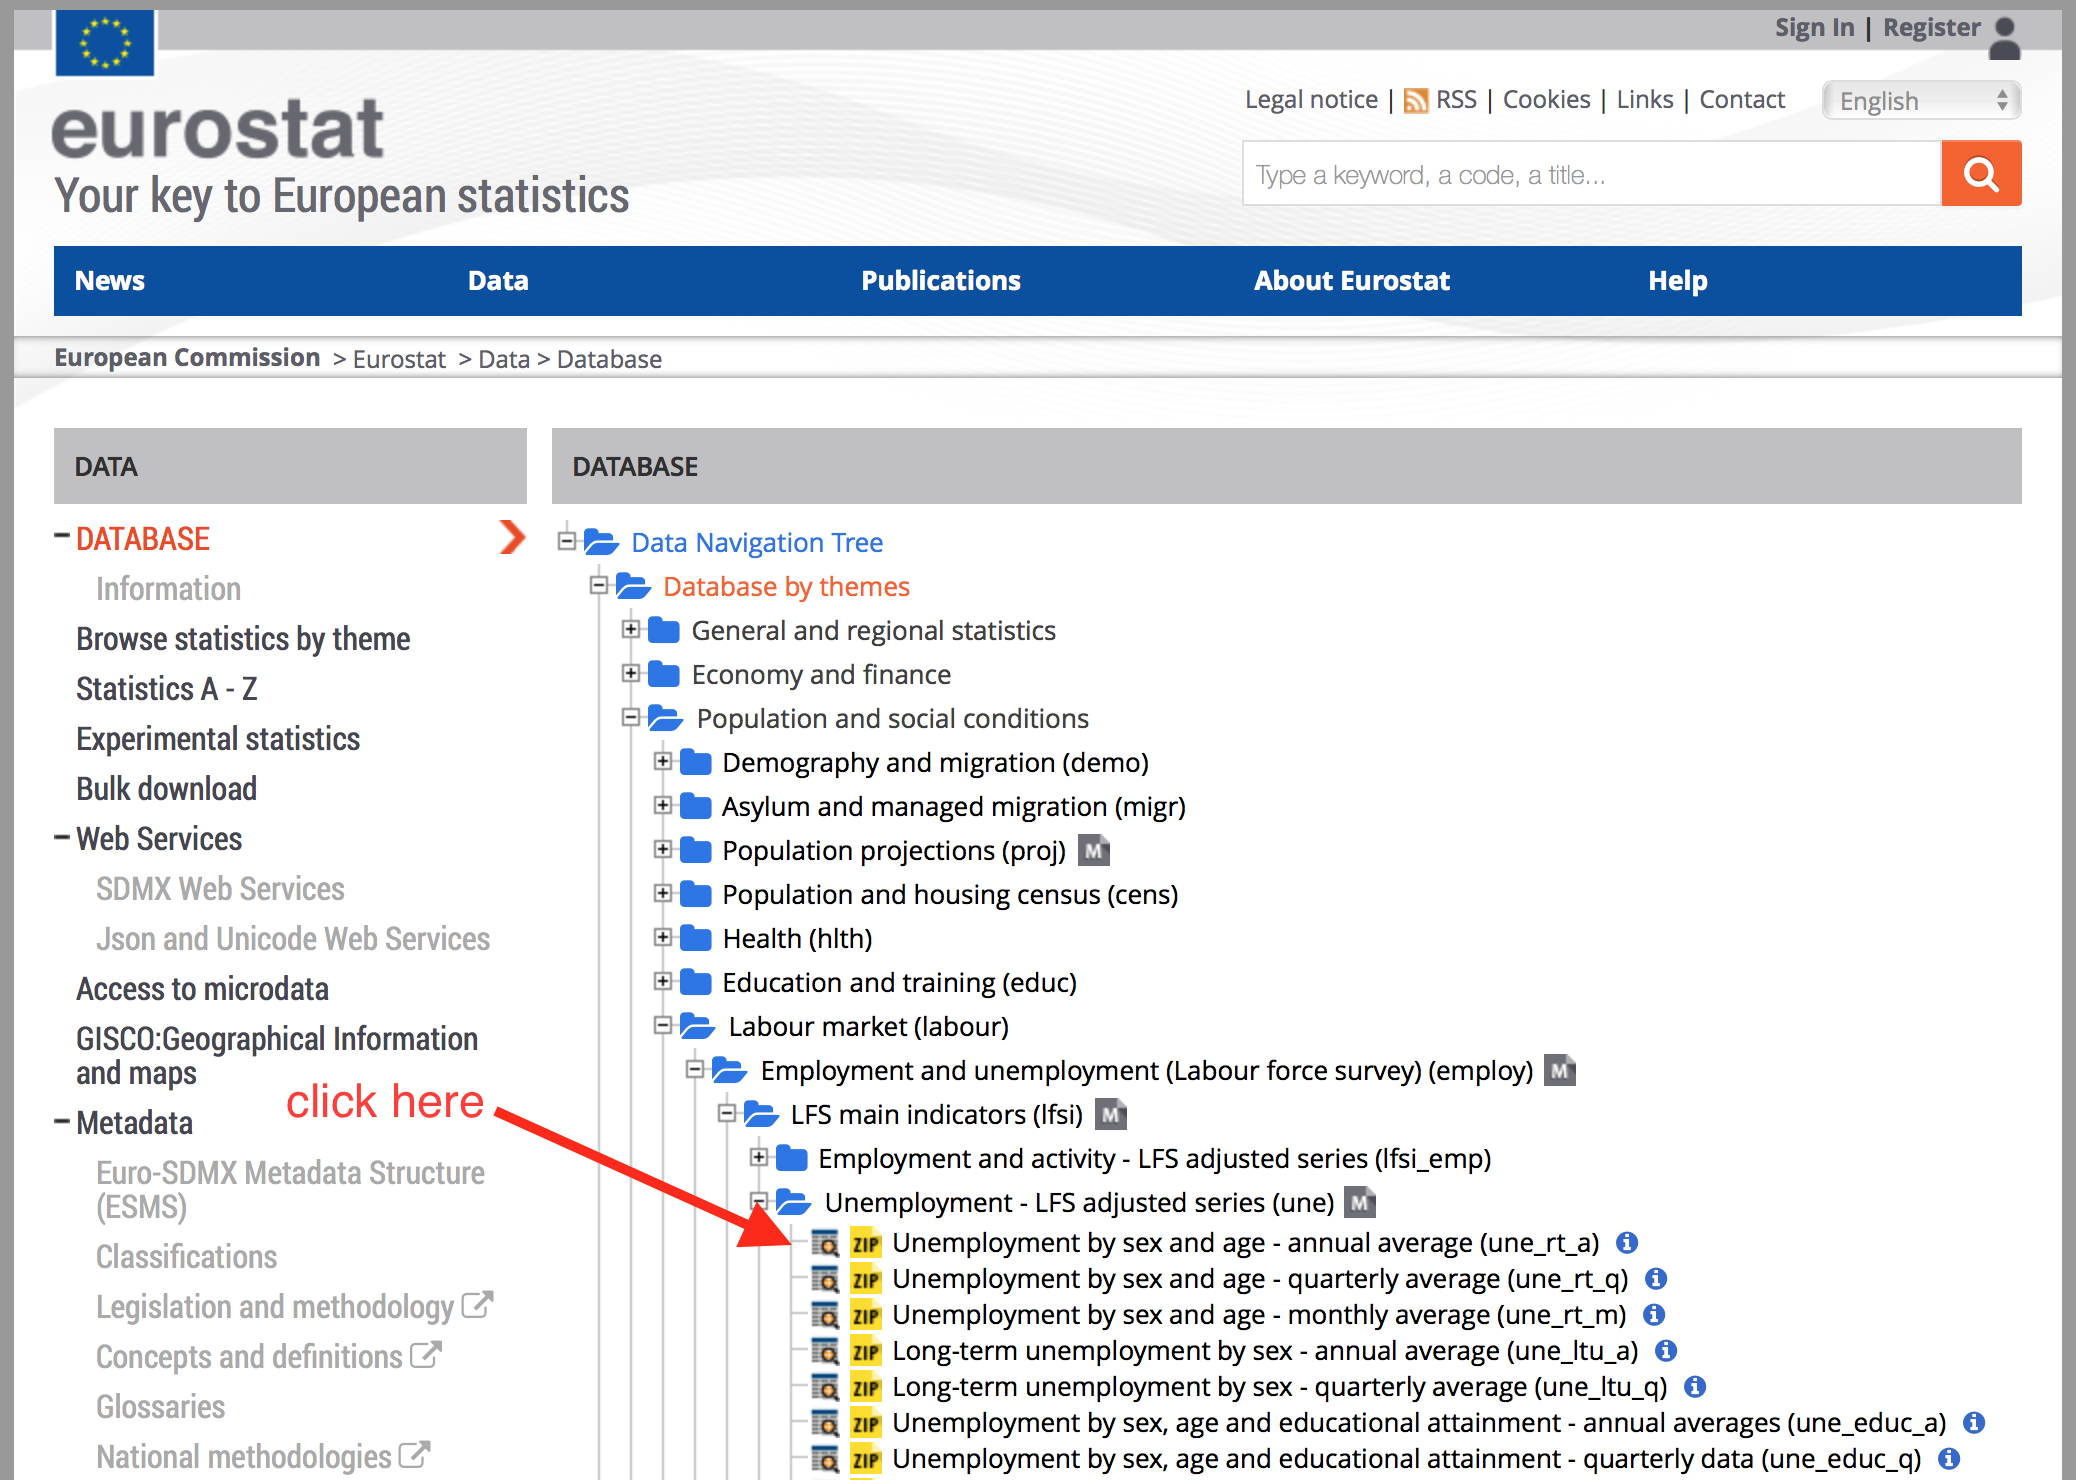

In [26]:
Image('./data/get_europe_rates.png')

## Swiss data

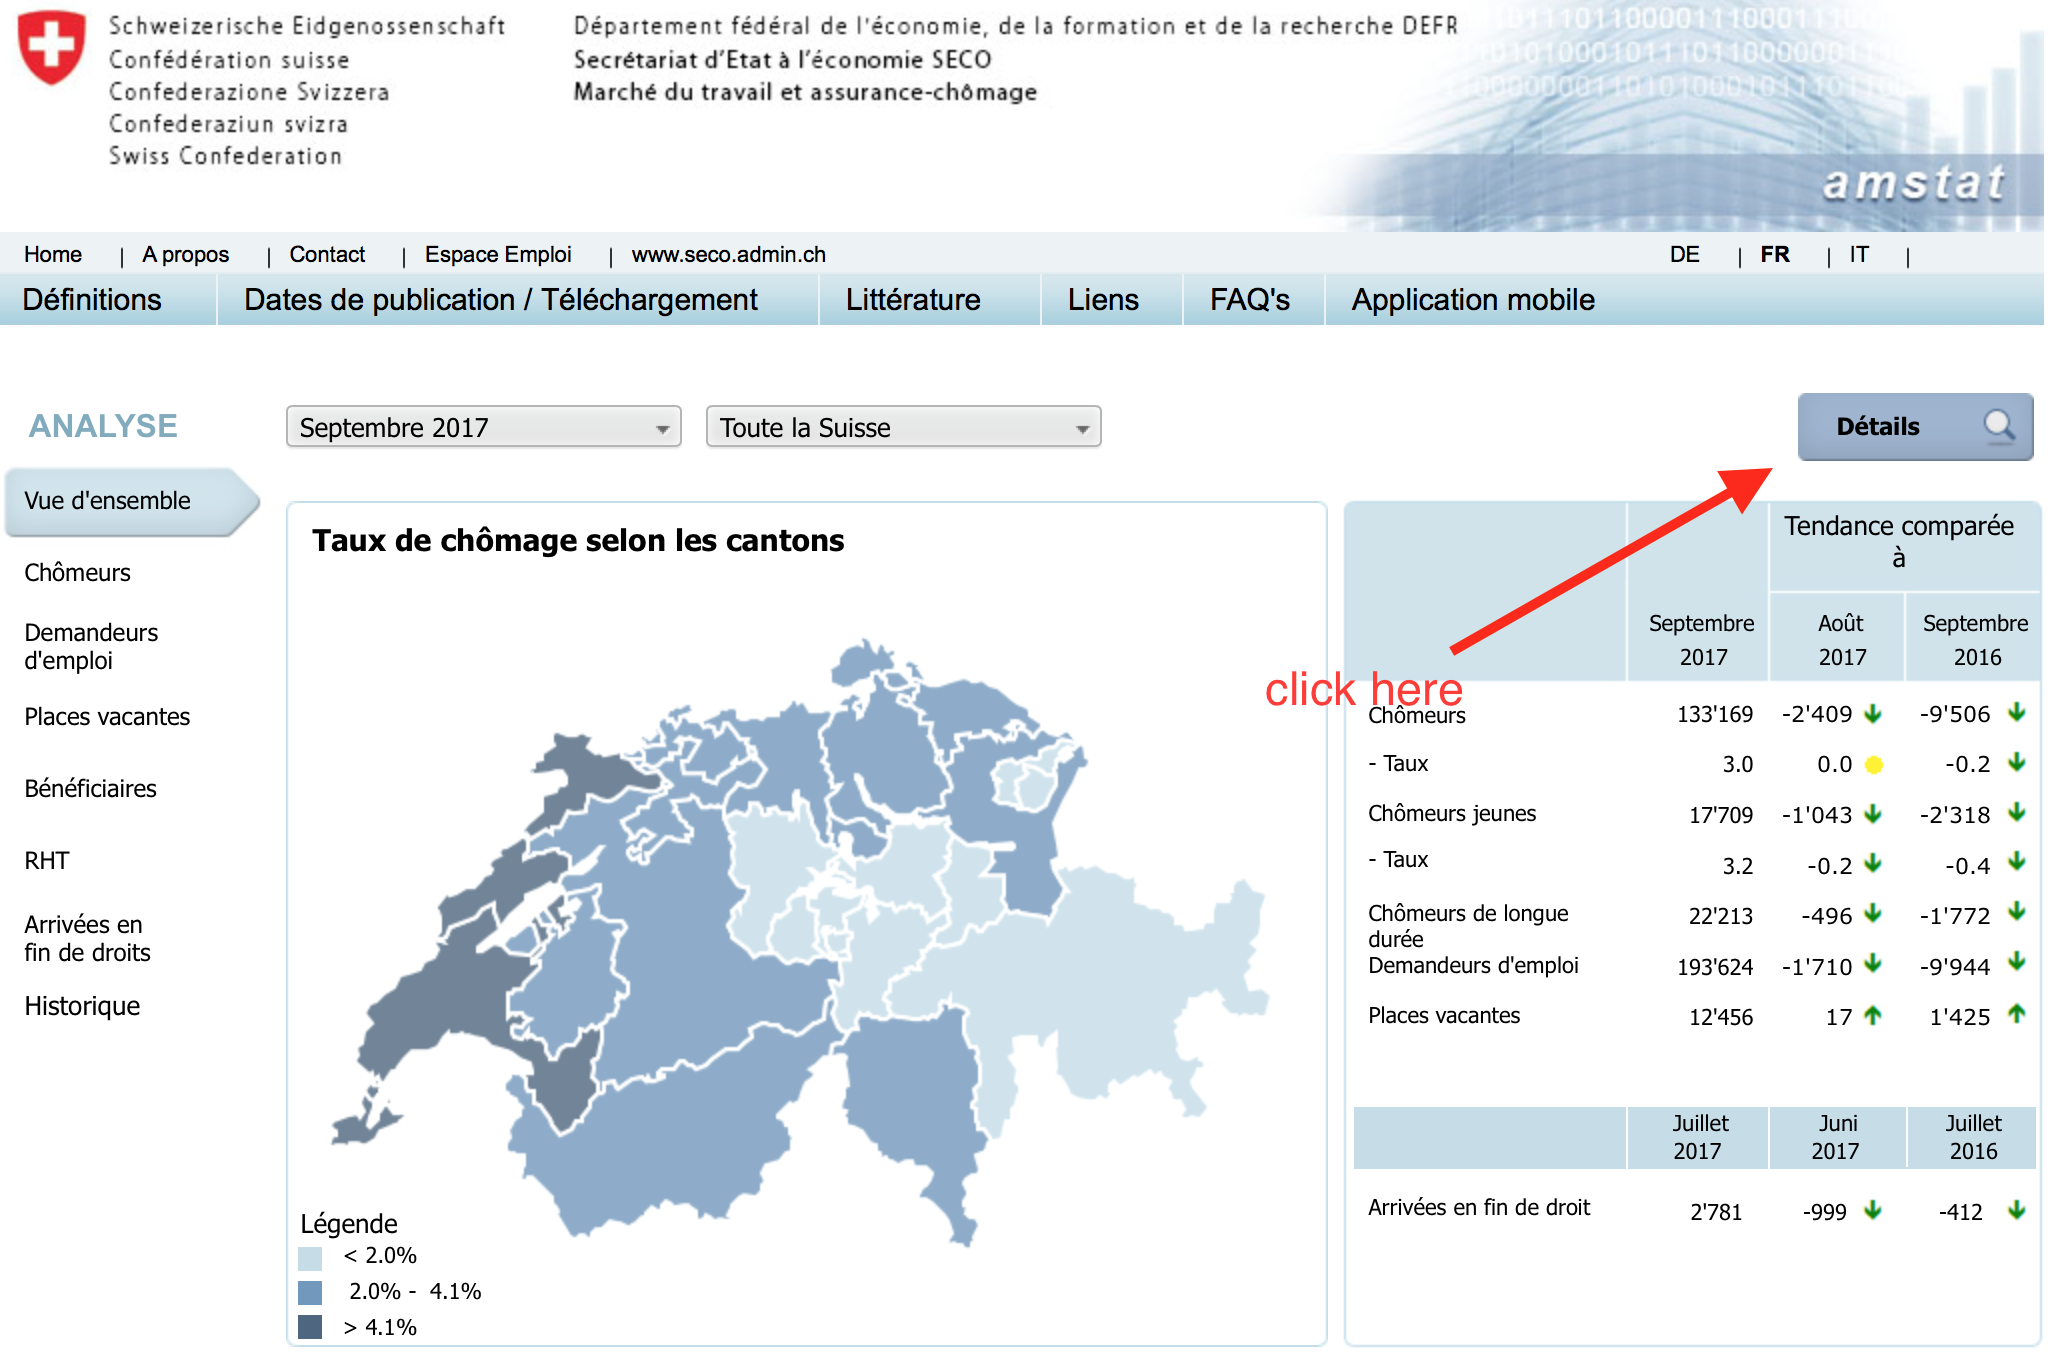

In [27]:
Image('./data/get_swiss_rates_1.png')

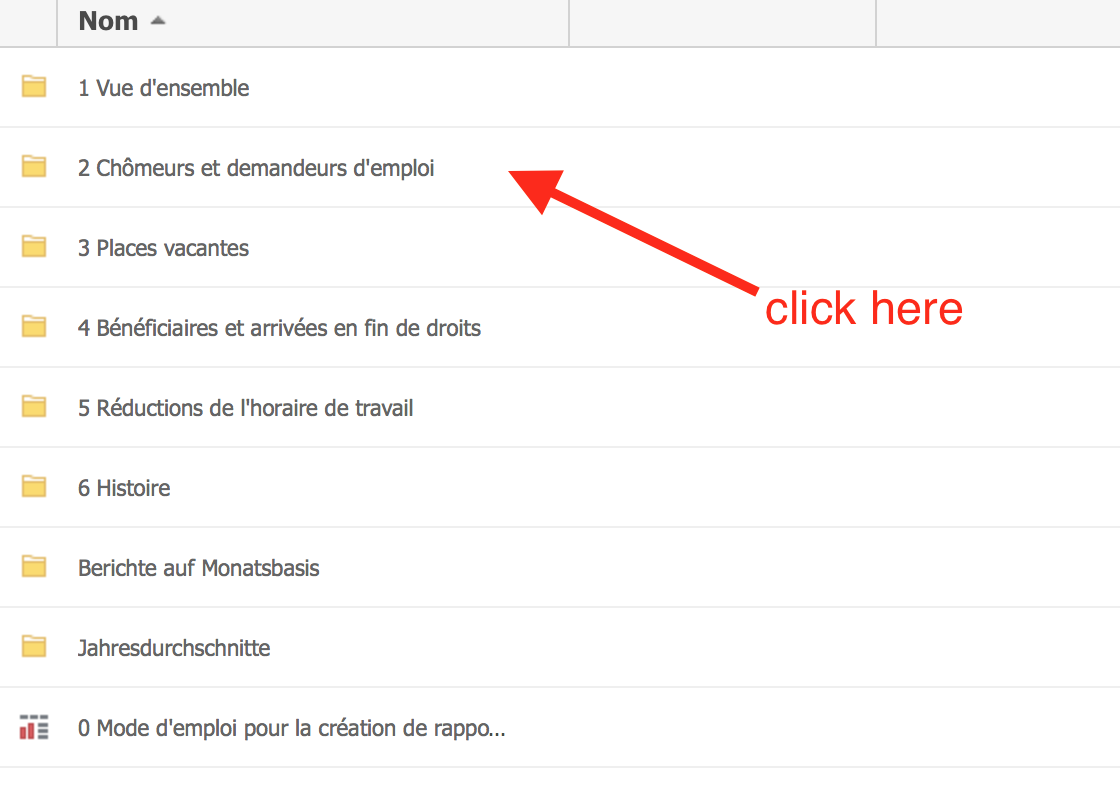

In [28]:
Image('./data/get_swiss_rates_2.png')

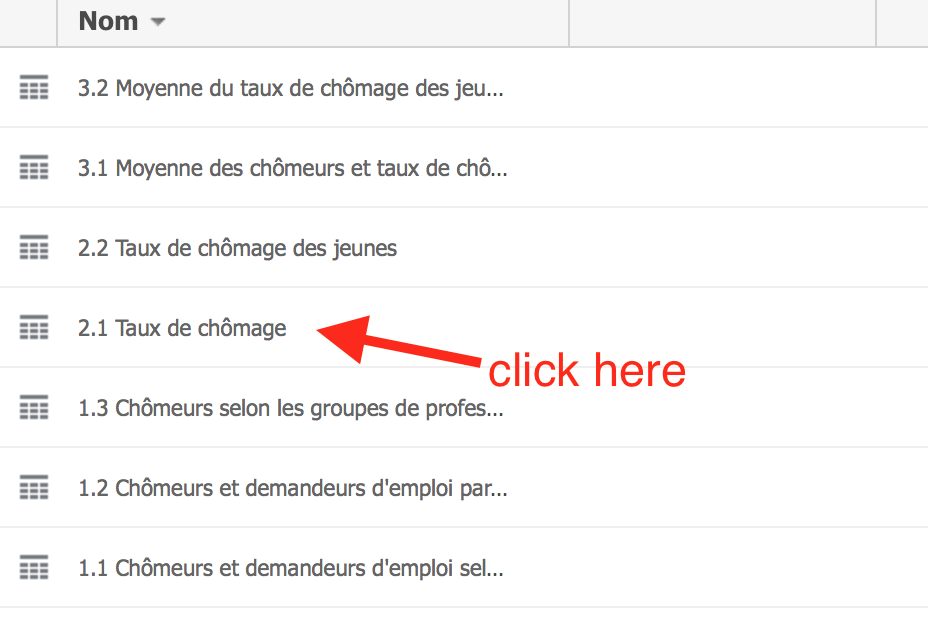

In [29]:
Image('./data/get_swiss_rates_3.png')

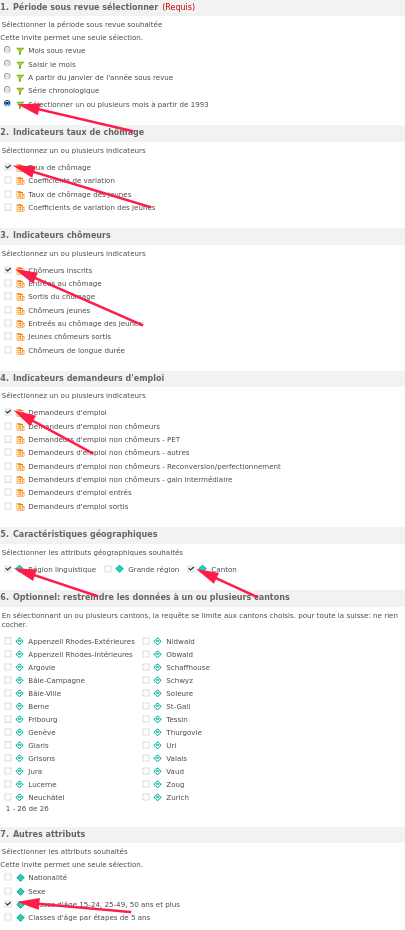

In [30]:
Image('./data/get_swiss_rates_4.png')

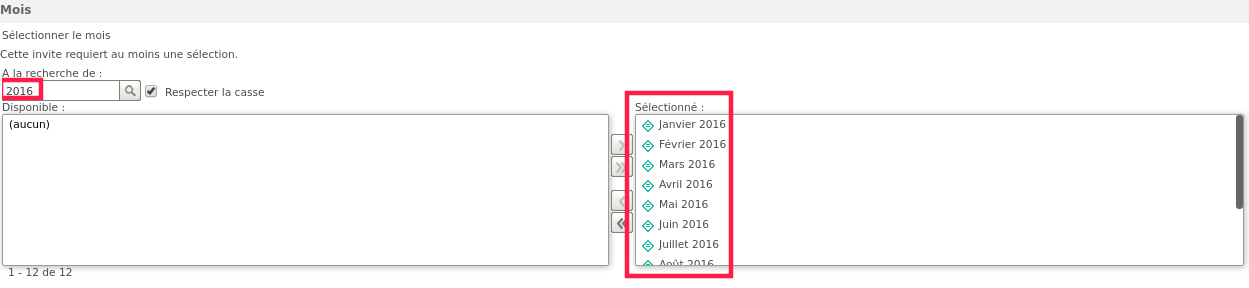

In [31]:
Image('./data/get_swiss_rates_5.png')